
# Climatology in Ny Ålesund using cluster analysis of atmospheric soundings

Jussi Tiira <jussi.tiira@helsinki.fi>, University of Helsinki, Department of Physics, Helsinki

NeGI 2017 School – Atmospheric science at high latitudes: Online data storage and visualization tools, Hyytiälä, Finland

Project report

## Abstract <a class="tocSkip">
The daily radiosounding data recorded in Ny Ålesund since 1994 hold information on the climatology of the atmospheric column above the measurement site. Multivariate cluster analysis using $k$-means was performed on 20 years of the sounding data to analyze patterns in the wind, temperature and relative humidity profiles. Six profile classes were identified and their characteristics described. The classification can be used as a proxy for airmass and weather type and their frequency analysis.

## Introduction

A wide range of atmospheric variables are measured around Ny Ålesund research town in Svalbard including various aerosol measurements. The occurrence of most types of aerosol events such as arctic haze depend strongly on the meteorological conditions, and therefore it is interesting to compare how these events and conditions co-occurr. Often the occurrence of aerosol events is compared separately against single meteorological variables such as wind direction or relative humidity. However, the meteorological variables and their vertical profiles are interconnected and can be used together to describe the atmospheric state. The aim of this project is to combine the vertical profiles of wind speed and direction, temperature and relative humidity as measured with Ny Ålesund atmospheric soundins to create a classification for the profiles, specific to the location.

Radiosondes have been important measurement instruments for atmospheric scientists since the 19th century and are still widely used today. They are the most inexpensive way for in situ measurements of the basic meteorological variables of an atmospheric column. Conditions in the boundary layer are usually less characteristic for the synoptic situation than those in free atmosphere. Therefore, sounding data are a more stable and meaningful basis for the classification when we want it to represent the atmospheric state.

The workflow for creating the classification and analyzing the results is shown in code cells along this report. To increase the readability of this report, most of the analysis code is written in separate python modules and is called in this notebook, where needed. We start by setting up the environment with required modules and settings.

In [58]:
# Matplotlib magic. Change to "notebook" for interactive plots.
%matplotlib inline
# Set rest of the plotting environment
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats, display, Markdown, HTML
set_matplotlib_formats('pdf', 'png')
plt.rcParams['animation.html'] = 'html5'
plt.rcParams['figure.dpi'] = 200 # plot resolution
plt.rcParams['figure.figsize'] = 10, 6 # default figure size

import importlib as imp
import datetime
import numpy as np
# constant seed to random number generator to make results reproducible
np.random.seed(42)
import pandas as pd
pd.set_option('display.max_columns', 15)
from os import path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# The below modules are written by me.
# The modules sonde and clustering are written specifically for this project.
import sonde
import clustering as cl
# j24 is my general purpose python module
from j24 import home, learn
from j24 import visualization as vis
from j24.notebook import Caption, show
# Reload changes in the modules.
imp.reload(cl)
imp.reload(sonde)

# Assign figure numbers
f_k = 1
f_profs = 2
f_wind = 3
f_year = 4
f_occ = 5

## Methods

### Data

In this project we use daily Ny Ålesund atmospheric sounding data from years 1996 to 2016 <cite>(Maturilli and Kayser 2016; 2017)</cite><span style="display:none;"><cite data-cite="1877461/GSQJ78FJ"></cite><cite data-cite="1877461/36YJ2LS4"></cite></span> to make the classification. The daily soundings are measured around 11 UTC. In this study we use the wind vector ($\mathbf{V}$), temperature ($T$) and relative humidity ($\mathit{RH}$) profiles from the soundings. The data was retrieved from [Pangaea](https://pangaea.de/) and is licensed under [Creative Commons Attribution 3.0](https://creativecommons.org/licenses/by/3.0/).

#### Preprocessing

Pandas <cite data-cite="1877461/PZBR4C34"></cite> Python module was used for reading the sounding data. Prior to the clustering process, some filtering and other preprocessing was performed. For some days there are additional soundings, that need to be excluded for consistency of the time of the day. In this study only soundings performed between 10 and 12 UTC are used, which includes all the regular daily soundings. The analysis should be limited to only tropospheric data, and therefore profiles are cut at 10 km.

In the sounding data, wind vectors are expressed as wind speed and direction. In the point of view of the clustering, the problem with this format is that wind direction is not a continuous value. Therefore, the wind vector is transformed into southerly and westerly components, $u$ and $v$ respectively.

After the filtering and other preprocessing, the resulting data was saved in HDF5 binary format. First, we load the data:

In [2]:
# Read previously processed data from HDF5 file.
datadir = path.join(home(), 'DATA', 'pangaea', 'sonde') # data path
#datadir = '.'
storage_path = path.join(datadir, '96-16prep.h5')
data = pd.read_hdf(storage_path, 'data')
# data in preprocessed HDF5 format can be requested from the author

data.tail() # show the last rows of the preprocessed data
# Columns date, u and v were added in the preprocessing phase.

,time,id,h,lat,lon,p,t,rh,ws,wd,date,u,v
149494,2016-12-31 11:35:20,L4643498,9800,78.79,11.71,240.2,-60.7,8.0,9.8,354.0,2016-12-31,1.024379e+00,-9.746315
149495,2016-12-31 11:35:32,L4643498,9850,78.79,11.72,238.3,-60.6,7.0,10.1,356.0,2016-12-31,7.045404e-01,-10.075397
149496,2016-12-31 11:35:44,L4643498,9900,78.79,11.72,236.4,-60.6,6.0,10.3,358.0,2016-12-31,3.594648e-01,-10.293726
149497,2016-12-31 11:35:57,L4643498,9950,78.79,11.72,234.5,-60.5,6.0,10.4,359.0,2016-12-31,1.815050e-01,-10.398416
149498,2016-12-31 11:36:09,L4643498,10000,78.79,11.72,232.7,-60.2,6.0,10.6,360.0,2016-12-31,3.245314e-15,-10.600000


All the soundings from the 20 year time span are now in one single table. Below, we extract wind, temperature and relative humidity tables from this master table.

In [3]:
# select wind, temperature and relative humidity profiles for clustering
ww = cl.wind4clus(data) # wind u and v components 
tt = cl.t4clus(data, col='t') # temperature
hh = cl.t4clus(data, col='rh') # relative humidity
clus_vars = (ww, tt, hh)

tt.tail() # show a part of the temperature data

date,1996-01-01 00:00:00,1996-01-02 00:00:00,1996-01-03 00:00:00,1996-01-04 00:00:00,1996-01-05 00:00:00,1996-01-06 00:00:00,1996-01-08 00:00:00,...,2016-12-20 00:00:00,2016-12-22 00:00:00,2016-12-24 00:00:00,2016-12-25 00:00:00,2016-12-27 00:00:00,2016-12-29 00:00:00,2016-12-31 00:00:00
h,,,,,,,,,,,,,,,
250,-23.8,-24.4,-26.2,-24.4,-16.3,-13.6,-5.3,...,-6.0,-0.3,-7.0,-5.7,-3.6,-3.5,-9.9
200,-23.4,-24.0,-25.9,-24.2,-16.8,-13.4,-4.8,...,-5.5,0.2,-6.5,-5.2,-3.2,-3.0,-9.7
150,-23.2,-23.6,-25.6,-23.9,-16.9,-13.3,-4.3,...,-5.0,0.5,-6.1,-4.8,-2.9,-2.6,-9.4
100,-23.0,-23.2,-25.3,-23.4,-16.8,-13.3,-3.9,...,-4.6,0.9,-5.6,-4.3,-2.8,-2.0,-9.0
50,-23.5,-23.3,-25.4,-23.2,-16.9,-13.4,-3.6,...,-4.6,1.1,-5.4,-4.4,-3.6,-1.6,-9.6


In the above table, each sounding is represented by one column. There are {{tt.shape[1]}} soundings in the data.

### $k$-means clustering

In this study, the widely used $k$-means <cite data-cite="1877461/UCI867CQ"></cite> method was chosen for cluster analysis, as it is suitable for multivariate cluster analysis and simple to use. It is often a good first guess when choosing a clustering method, and given the limited time frame of the course this study was made in, there was not enough time to experiment with other methods. Limitations of the method include the assumption of spherical clusters, and the possibility to converge into a local minimum which may result in counterintuitive results. The latter limitation is addressed by using the $k$-means++ method <cite data-cite="1877461/U94IETZ6"></cite> to distribute the initial cluster seeds in a clever way. In this study, $k$-means++ is repeated 10 times and the best result in terms of sum of squared distances of samples to their closest cluster center is used for seeding.

#### Selecting the number of classes

An important but non-trivial consideration in using $k$-means clustering is the choice of number of clusters, $k$. Several methods exist for estimating the optimal number. In this study we use silhouette analysis <cite data-cite="1877461/TC8YVN3I"></cite>, which is a method for measuring how far each sample (defined by profiles of $T$, $\mathbf{V}$ and $\mathit{RH}$ in a given sounding in our case) is from other clusters (separation) compared to its own cluster (cohesion). This distance, silhouette coefficient $s$, takes values between -1 and 1. The higher the value, the better the sounding represents the cluster it is assigned to. A sounding with $s=0$ would be a borderline case between clusters, and negative values indicate that the soundings might have been assigned to wrong clusters.

The optimal number of clusters depends on variability of meteorological conditions and correlations between different variables. The more variability and degrees of freedom, the more clusters are generally needed to describe different features in a dataset. On the other hand, a large number of clusters would make the resulting classification complicate to interpret. Taking these considerations into account we could conclude that an optimal $k$ for this project should be around 5.

In [4]:
# numbers of clusters to test
n_min = 2
n_max = 11
n_clus = list(range(n_min, n_max+1))
s1 = '''The metric used in this project to help to decide $k$ is the mean silhouette coefficient,
termed silhouette score, $\overline{s}$. '''
s2 = 'The score is calculated for $k \in [{n_min}, {n_max}]$:'.format(n_min=n_min, n_max=n_max)
Markdown(s1+s2)

The metric used in this project to help to decide $k$ is the mean silhouette coefficient,
termed silhouette score, $\overline{s}$. The score is calculated for $k \in [2, 11]$:

In [5]:
# wtr: "wind, temperature, humidity", isplit: indices used later for resplitting
wtr, isplit = cl.concat(clus_vars)
# Calculate silhouette scores for each number of clusters in n_clus.
# May take several minutes.
scores = cl.scores(wtr, n_clus=n_clus, score_func=silhouette_score)

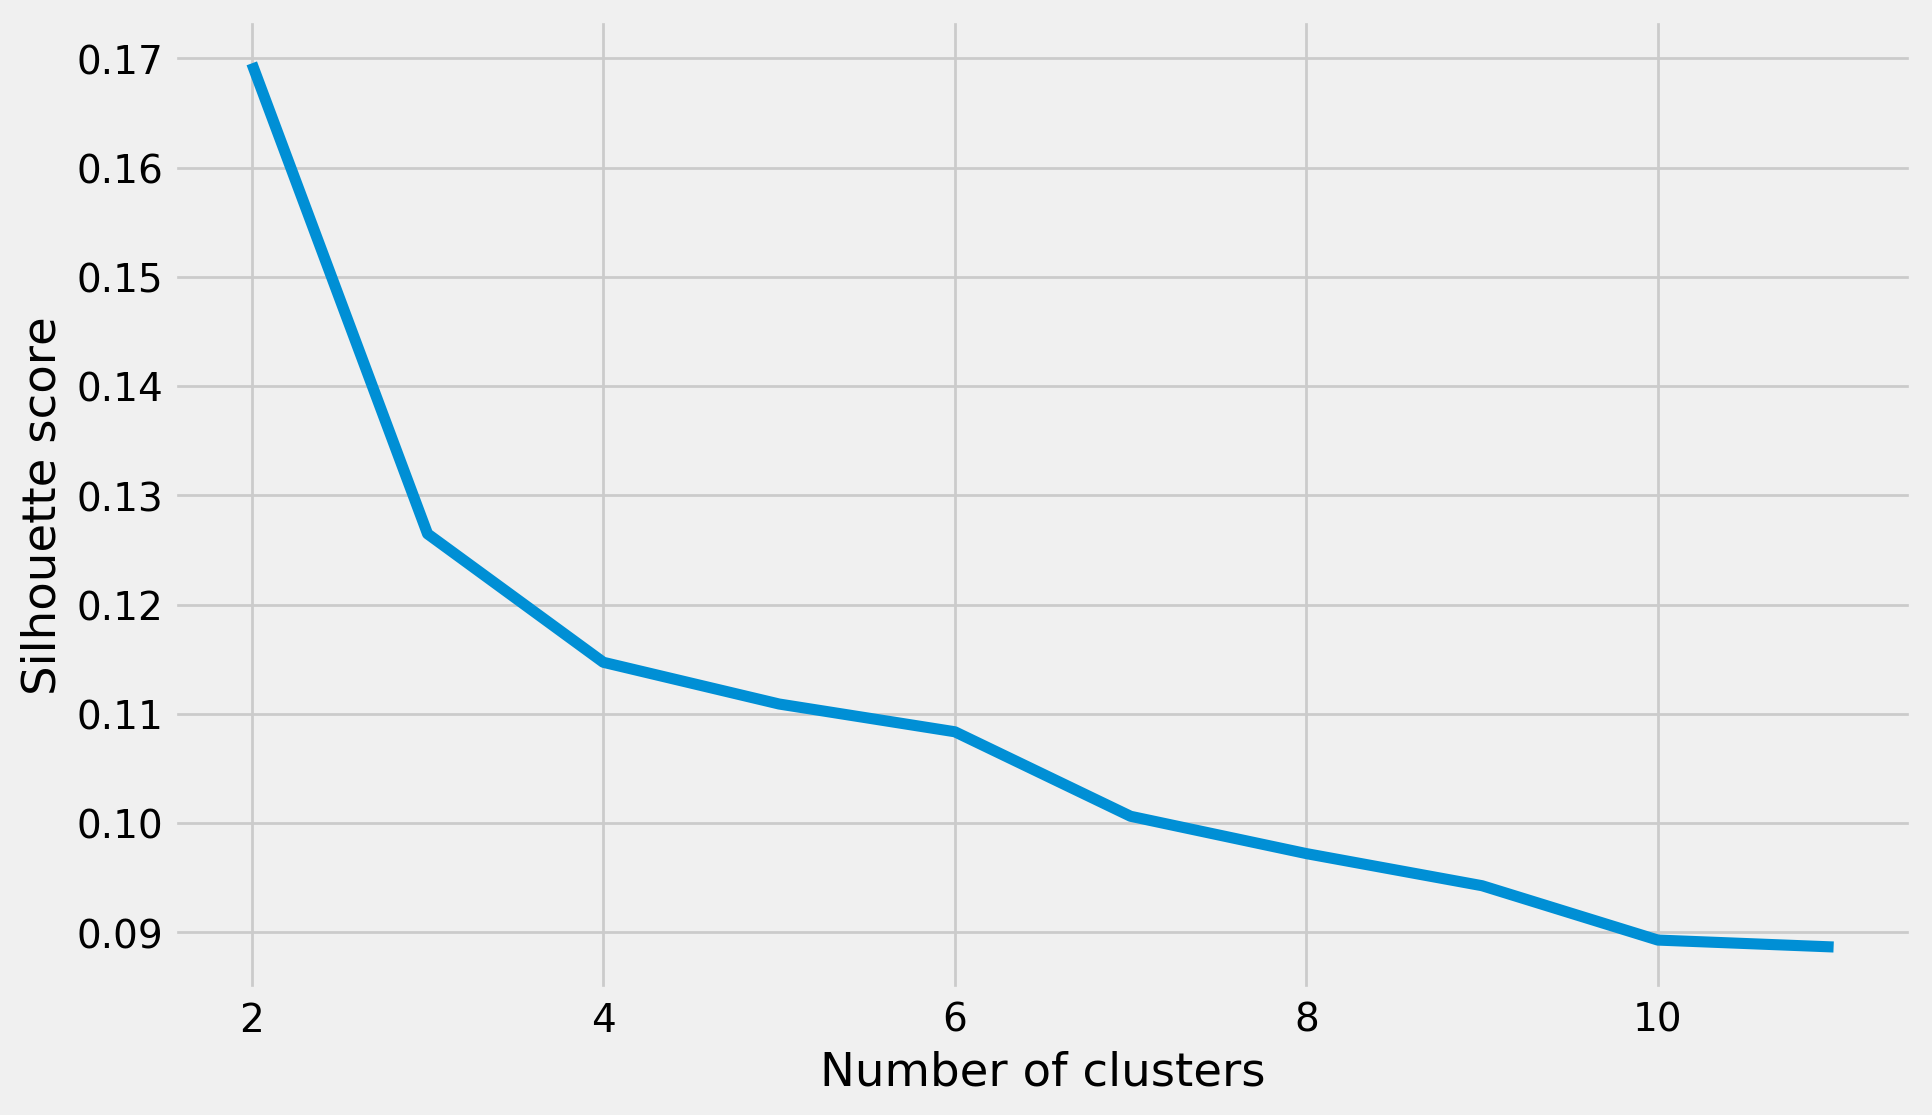

In [6]:
# Plot the scores
with plt.style.context('fivethirtyeight'):
    fig_k, ax_k = plt.subplots(num=f_k)
    cl.plot_scores(n_clus, scores, ax=ax_k)
show(fig_k, caption='Silhouette score for $k$-means as a function of number of clusters for soundings.')

In [7]:
# Choose the number of clusters.
k = 6

In Figure {{f_k}}, we see that $\overline{s}$ decreases with increasing $k$ in the studied range. There is little difference between the scores of 4 to 6 clusters, but after $k = 6$, there is a drop in the score. For this project we choose $k = 6$, but depending on the application, some other value could be used as well.

We proceed to performing the clustering and retrieving cluster centroids:

In [8]:
# Setup k-means with k clusters. Seed using k-means++ 10 times.
km = KMeans(init='k-means++', n_clusters=k, n_init=10, n_jobs=-1)
classes = learn.fit_predict(wtr, km) # Perform the clustering and obtain results.
cen = learn.centroids(wtr, km) # cluster centroids
# Split centroids of wind, temperature and humidity, cw, ct and ch, respectively.
cw, ct, ch = cl.split(cen, isplit)

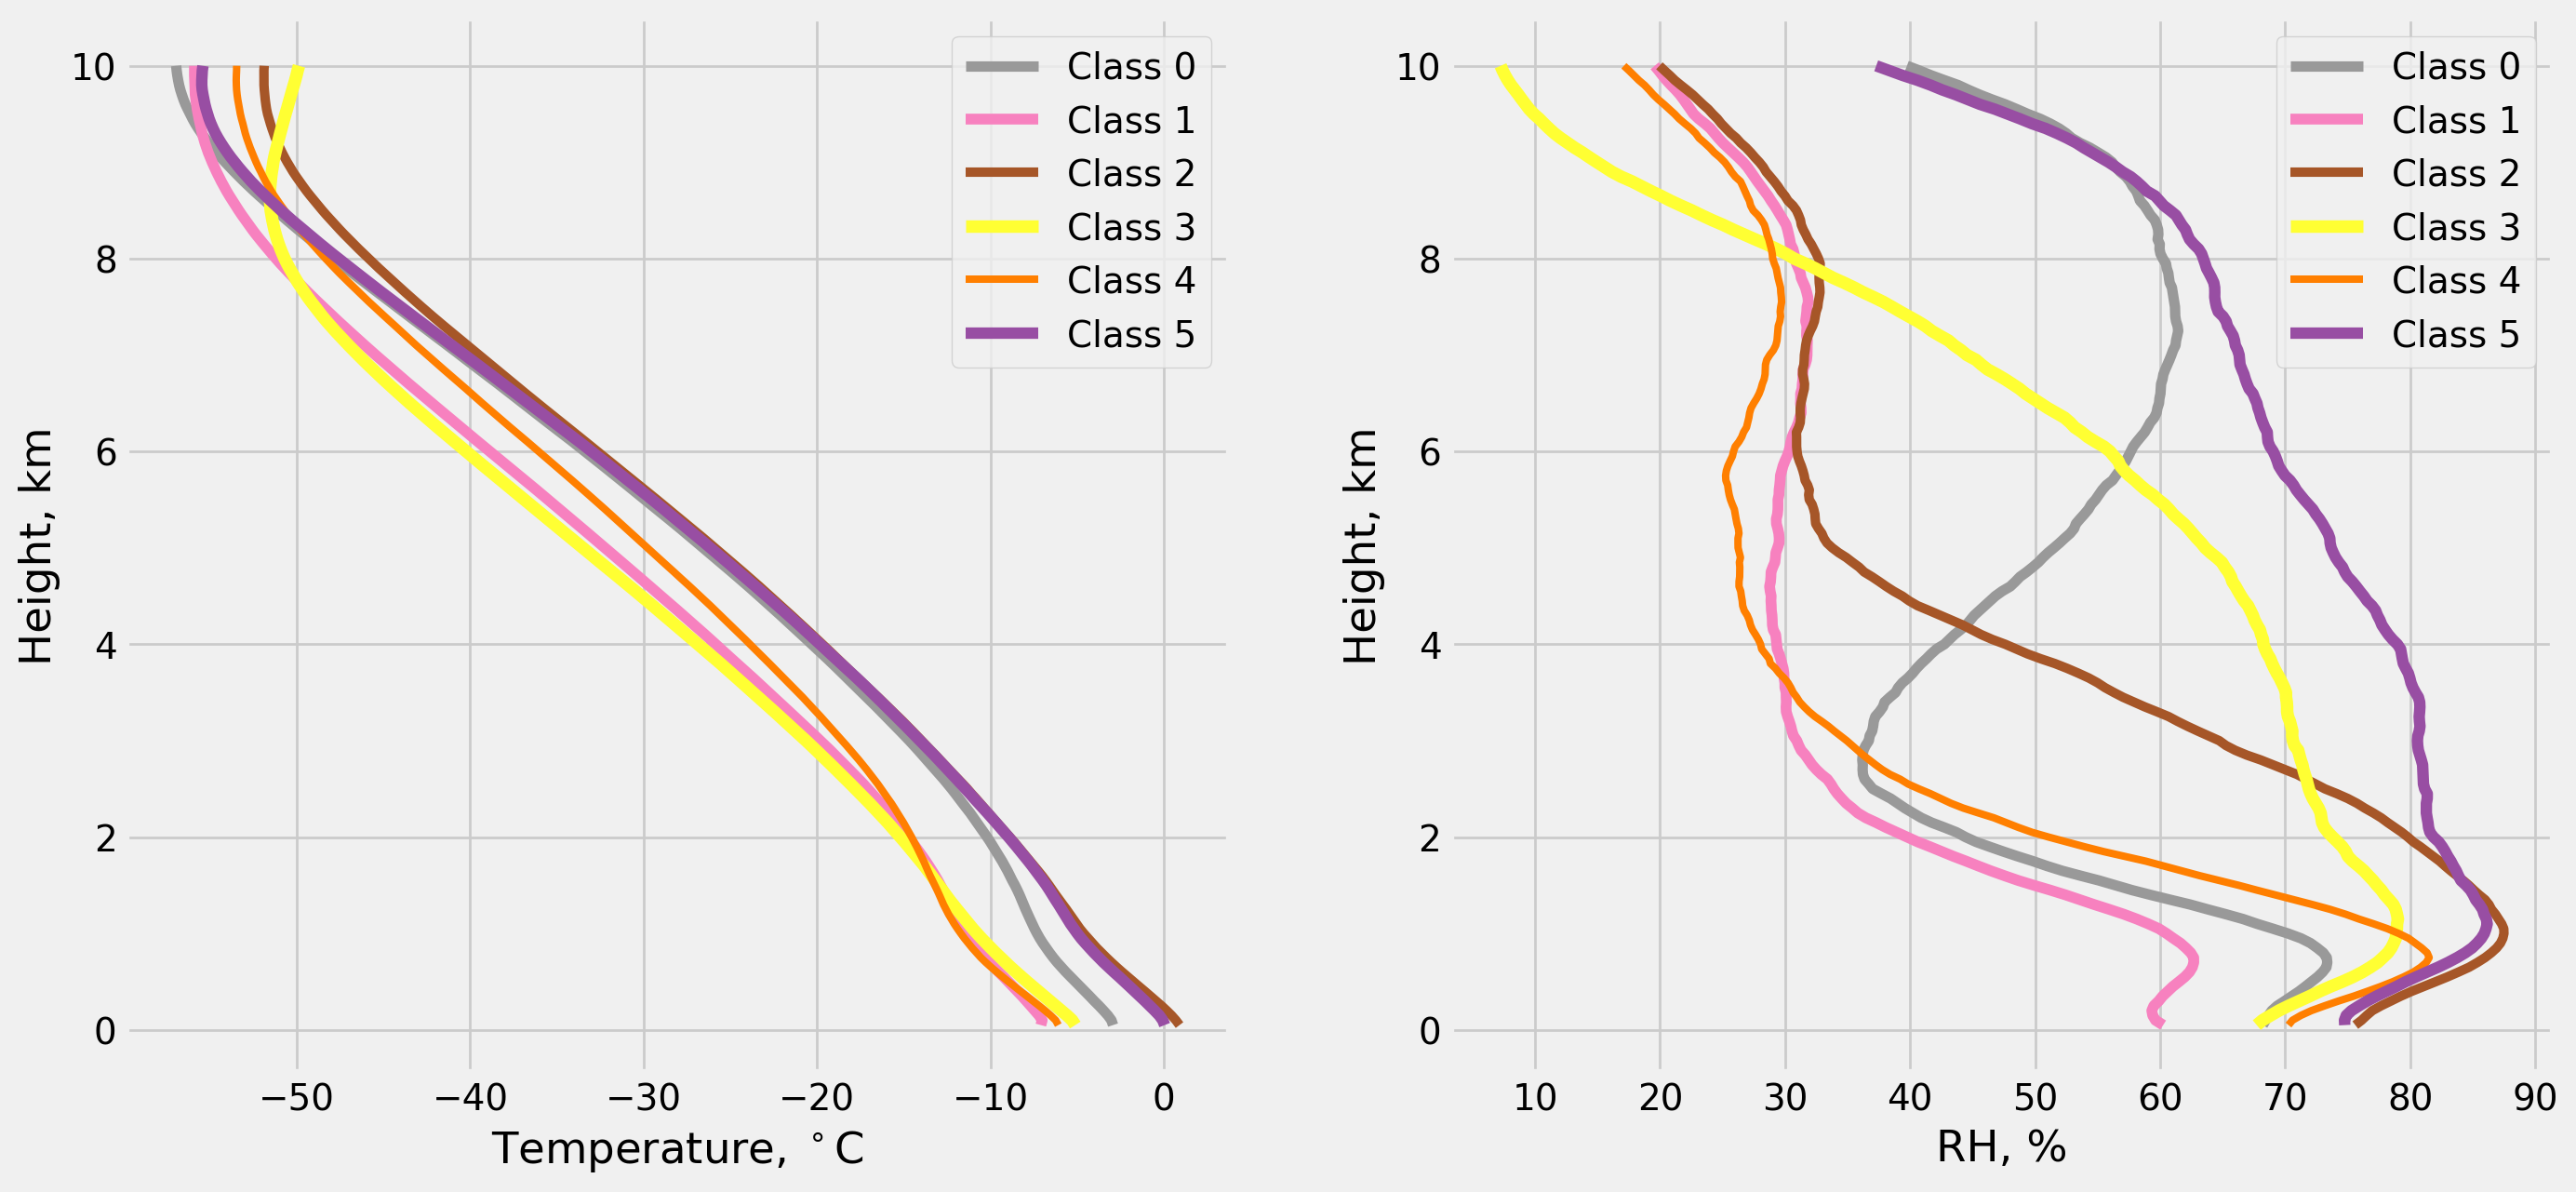

In [9]:
# Calculate the size of each class.
class_sizes = learn.normalized_class_sizes(classes)
# Make line widths proportional to class size.
linewidths = class_sizes*4
# Plot class centroid temperature and RH profiles.
with plt.style.context('fivethirtyeight'):
    fig_profs, axarr = plt.subplots(1, 2, figsize=(15, 7), num=f_profs)
    cl.plot_profiles(ct, ax=axarr[0], linewidths=linewidths)
    axarr[0].set_xlabel('Temperature, $^\circ$C')
    cl.plot_profiles(ch, ax=axarr[1], linewidths=linewidths)
    axarr[1].set_xlabel('RH, %')
capt = '''
Temperature and relative humidity profiles of the $k$-means cluster centroids. 
Line widths are proportional to the cluster sizes.'''
show(fig_profs, caption=capt)

Class centroid profiles of $T$ and $\mathit{RH}$ are shown if Fig. {{f_profs}}. All classes seem to include a significant number of days with low stratiform clouds at around 1 km altitude, which is seen as an increase in the relative humidity around this height. Classes representing high ground temperatures $T_g$, namely 2 (brown) and 5 (purple), seem to have the most moist soundings near the surface implying the highest frequency of the mentioned stratiform clouds. The low level cloud height and thickness seem to be also highest within these two classes.

Class 1 (pink) represents the days with lowest ground temperatures. The slight increase in relative humidity right above the surface is an indicator of inversion cases in this class. Class 3 (yellow), seems to be the more moist version of class 1, with high probability of mid level clouds. The shape of the upper part of the $T$ profile of class 3 indicates it represents lower tropopause heights compared to the other classes.

Class 0 seems to represent situations with high clouds, and warm upper troposphere.

Visualizing the profiles of two dimensional wind vectors in an easy to read format is not trivial. We could plot the components separately, but perceiving such representation is not intuitive. Here is where we can make use of the great potential of Jupyter Notebooks by animating a rotated 3 dimensional (3D) plot for better perception of the structure of the profiles. Due to technical limitations, the animated version is only available when this report is viewed in Notebook or HTML format.

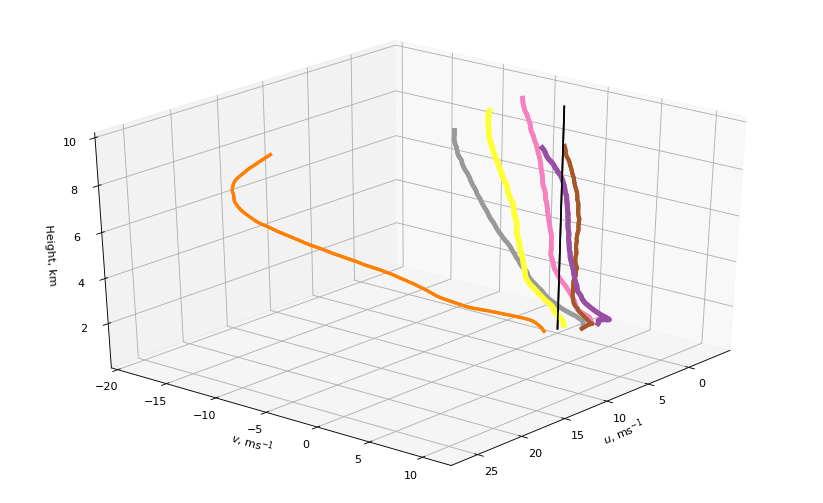

In [70]:
# Make animated 3D plot of cluster centroid wind profiles.
fig_wind = plt.figure(f_wind, dpi=80)
ax_wind = Axes3D(fig_wind)
ax_wind.set_ylim3d(-20, 12)
#ax_wind.set_aspect('equal')
#show(fig_wind, caption='Wind profiles of the class centroids.')
angles = np.linspace(0,360,81) # A list of 80 unique angles
# viewing angles to make the plot gently rotate back and forth
views = np.sin(np.deg2rad(angles))*15 + 40

def init():
    """Initialize the view."""
    cl.plot_w_centroids(cw, linewidths=linewidths, ax=ax_wind)
    return fig_wind,

def animate(i):
    """Animating the view."""
    ax_wind.view_init(elev=30, azim=i)
    return fig_wind,

# Create animation object.
anim = animation.FuncAnimation(fig_wind, animate, init_func=init, frames=views, interval=200, blit=True)
capt = '''Figure {}: Class centroid wind profiles 
for classes 0 (gray), 1 (pink), 2 (brown), 3 (yellow), 4 (orange) and 5 (purple). 
Line widths are proportional to the number of soundings in each class.'''
display(HTML(anim.to_html5_video()), Caption(capt.format(f_wind))) # Display as html5 video.

In Fig. {{f_wind}} we see that in the free atmosphere, there are three major wind directions: South-Westernly, Northernly and Westernly winds. We also see that wind direction near the ground can be quite different. Notably, class 4 represents situations with strong North-Westernly flow.

Next, we will look at the seasonal variability of the class occurrence.

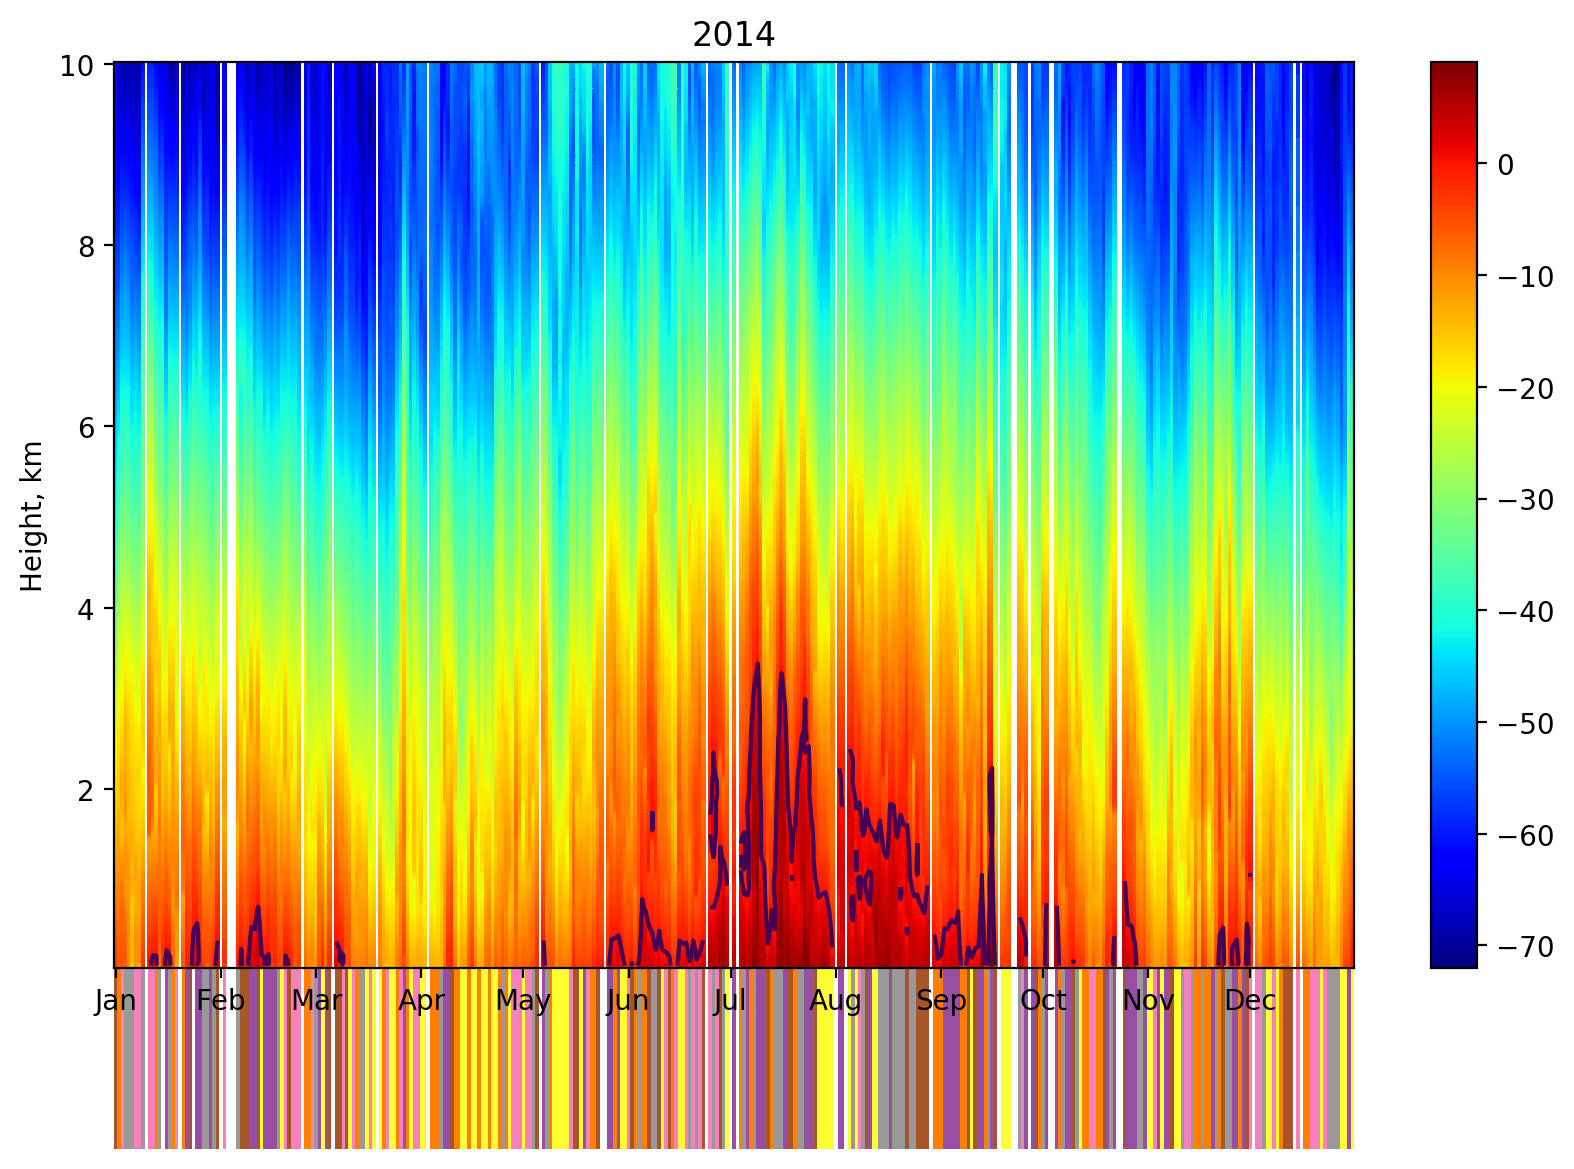

In [53]:
year = 2014 # change this to look at other years
start = datetime.datetime(year-1, 12, 31)
end = datetime.datetime(year+1, 1, 1)
t = sonde.resample_transpose(tt)
selection = (t.columns<end) & (t.columns>start)
t = t.loc[:,selection]
cla = classes.resample('1D').asfreq()
sel = (cla.index<end) & (cla.index>start)
cla = cla.loc[sel]

fig_year, ax_year = plt.subplots(num=f_year)
sonde.heatmap(t, classes=cla, ax=ax_year)
vis.fmt_axis_date(ax_year.xaxis)
vis.contour(t, ax=ax_year, levels=[0]) # plot melting temperature
#sonde.heatmap(h, classes=cla)
ax_year.set_title('{}'.format(year))
c1 = 'Temperature profiles for the year {}. '
c2 = '''
The $T=0^{\circ}$C level is marked with a solid line. 
The classification of individual profiles is denoted with color coding in the bottom.'''
show(fig_year, caption=c1.format(year)+c2)

In Fig. {{f_year}}, we see the temperature profiles and classification results for each individual sounding in {{year}}. The two very cold months after the end of the polar night, March and April, seem to have a high occurrence of class 3, marked with yellow color, whereas especially classes 0 and 5, in gray and purple, respectively, occur in the summer.

To see if this seasonal variability of the classes exists in the climatology, we next compare climatologically the coldest and the warmest months in Ny-Ålesund, March and July <cite data-cite="1877461/ZQI5Y7N9"></cite>, respectively.

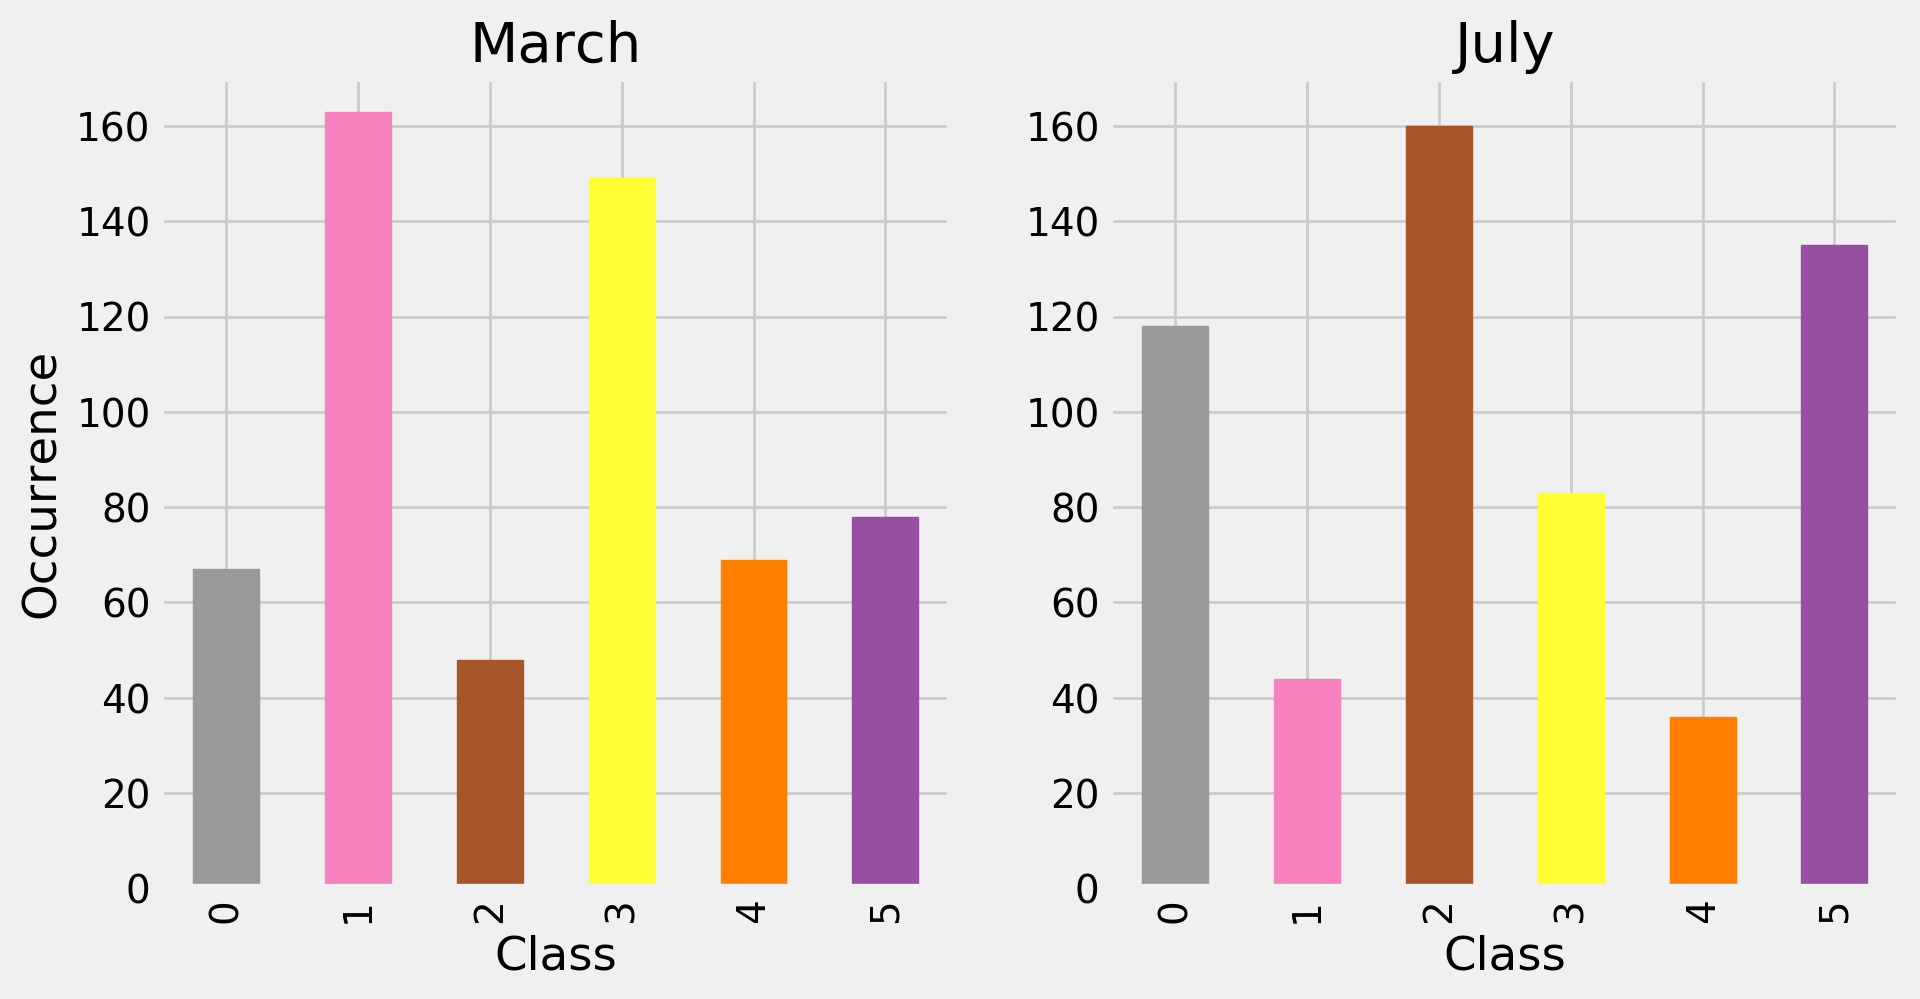

In [56]:
# make class occurrence bar plots
with plt.style.context('fivethirtyeight'):
    fig_occ, ax_occ = plt.subplots(1, 2, figsize=(10,5), num=f_occ)
    month = pd.Series(data=classes.index.month, index=classes.index)
    g = classes.groupby(month)
    mar = g.get_group(3)
    jul = g.get_group(7)
    pd.DataFrame(mar.groupby(mar).count()).plot.bar(ax=ax_occ[0])
    ax_occ[0].set_title('March')
    pd.DataFrame(jul.groupby(jul).count()).plot.bar(ax=ax_occ[1])
    ax_occ[1].set_title('July')
    for ax in ax_occ:
        ax.legend().set_visible(False)
        ax.set_ylim(top=170)
        ax.set_xlabel('Class')
        # color the bars according to classes
        pa = ax.patches
        check_rect = lambda p: isinstance(p, mpl.patches.Rectangle)
        pa = np.array(pa)[list(map(check_rect, pa))]
        for i, p in enumerate(pa):
            p.set_color(vis.class_color(i, cmap=sonde.DEFAULT_DISCRETE_CMAP))
    ax_occ[0].set_ylabel('Occurrence')
capt = 'Class occurrence in winter and summer.'
show(fig_occ, caption=capt)

In Fig. {{f_occ}} we see that there is a strong seasonal dependence in the occurrence of each class. The dependence is the highest for classes 1 and 2, and as we see in Fig. {{f_profs}}, these are the most dry and most wet classes, respectively, in the lowest kilometer. This is in good agreement with Maturilli and Kayser's (2017b)<span style="display:none;"><cite data-cite="1877461/36GQFSAL"></cite></span> Fig. 6.

## Conclusions

In this study, it was shown that $k$-means clustering can be applied on multivariate radiosounding data to produce meteorologically meaningful vertical profile classification. The choice for the number of classes to use is not trivial and should depend on the application of the classification. Here, we examined the features and seasonal occurrence of 6 classes. Scatter of the studied variables within each class was not analysed in detail in this study, but the low value of the silhouette score of 0.1 indicates, that major scatter likely occurs.

As the state of the atmospheric column is described by multiple interconnected variables, the classification can act as a kind of dimension reduction, where the only variable needed to describe the state is the class of a given sounding. The class could be then easily used for comparing against other datasets. Also statistical methods would be convenient to apply to a time series of profile classes. Further class frequency and trend analysis is out of the scope of this study but are potentially interesting applications of the classification for future studies.

## References

<div class="cite2c-biblio"></div>